# Machinery Model

> Library for machinery system, including combustion engine and fuel cell

In [ ]:
#| default_exp machinery
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

## Basic Types

In [ ]:
#| export
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from functools import cached_property
from typing import Optional, Union, Callable, List, TypeVar, NamedTuple
import numpy as np
from plotly.subplots import make_subplots
from plotly.graph_objs import Figure as PlotlyFigure
from ship_model_lib.utility import (
    get_interpolation_1d_function, Interpolated1DValue
)
from ship_model_lib.types import PropulsionType, EmissionType

Numeric = TypeVar("Numeric", np.ndarray, float)


@dataclass
class Point:
    x: float
    y: float


@dataclass
class Curve:
    points: List[Point] = field(default_factory=list)

    def add_point(self, point: Point):
        self.points.append(point)

    def to_x_array(self) -> np.ndarray:
        return np.array([point.x for point in self.points])

    def to_y_array(self) -> np.ndarray:
        return np.array([point.y for point in self.points])

    def get_curve_plot(
            self,
            name: str = "",
            y_label: Optional[str] = None,
            x_label: Optional[str] = None
    ) -> PlotlyFigure:
        fig = make_subplots()
        fig.add_scatter(x=self.to_x_array(), y=self.to_y_array(), name=name)
        if x_label is not None:
            fig.update_xaxes(title=x_label)
        if y_label is not None:
            fig.update_yaxes(title=y_label)
        return fig


@dataclass
class FuelByMassFraction:
    diesel: float = 0.0
    hfo: float = 0.0
    natural_gas: float = 0.0
    hydrogen: float = 0.0
    ammonia: float = 0.0
    lpg: float = 0.0
    marine_gas_oil: float = 0.0
    methanol: float = 0.0
    _LHV_DIESEL: float = 42.7
    _LHV_HFO: float = 40.8
    _LHV_NG: float = 47.3
    _LHV_Hydrogen: float = 120.0
    _LHV_Ammonia: float = 18.6
    _LHV_LPG: float = 45.5
    _LHV_MGO: float = 42.8
    _LHV_Methanol: float = 19.9
    _CO2_DIESEL: float = 3.15
    _CO2_HFO: float = 3.11
    _CO2_NG: float = 2.75
    _CO2_Hydrogen: float = 0.0
    _CO2_Ammonia: float = 0.0
    _CO2_LPG: float = 3.01
    _CO2_MGO: float = 3.15
    _CO2_Methanol = 1.37
    # kg CO2 / kg fuel from engineeringtoolbox.com

    def __post_init__(self):
        total_fraction = sum([
            getattr(self, fuel_type) for fuel_type in self.__dict__ if not fuel_type.startswith("_")
        ])
        assert total_fraction == 1.0, "The mass fraction must sum to 1."

    @property
    def lhv_mj_per_kg(self):
        """
        Returns the low heat value of fuel based on fuel mass fraction
        """
        return self.diesel * self._LHV_DIESEL \
            + self.hfo * self._LHV_HFO \
            + self.natural_gas * self._LHV_NG \
            + self._LHV_Hydrogen * self.hydrogen \
            + self._LHV_Ammonia * self.ammonia \
            + self._LHV_LPG * self.lpg \
            + self._LHV_MGO * self.marine_gas_oil \
            + self._LHV_Methanol * self.methanol

    def get_co_2_curve(self, efficiency: Curve) -> Curve:
        kg_co2_per_kg_fuel = self.diesel  * self._CO2_DIESEL \
                       + self.hfo * self._CO2_HFO \
                       + self.natural_gas * self._CO2_NG \
                       + self.hydrogen * self._CO2_Hydrogen \
                       + self.ammonia * self._CO2_Ammonia\
                       + self.lpg * self._CO2_LPG\
                       + self.marine_gas_oil * self._CO2_MGO \
                       + self.methanol * self._CO2_Methanol
        kg_co2_per_kwh = 1/(self.lhv_mj_per_kg / 3.6) * kg_co2_per_kg_fuel
        co_2_points = []
        for point in efficiency.points:
            g_co2_per_kwh_shaft = kg_co2_per_kwh * 1000 / point.y
            co_2_points.append(Point(x=point.x, y=g_co2_per_kwh_shaft))
        return Curve(co_2_points)


class FuelConsumption:
    diesel: float = 0.0
    hfo: float = 0.0
    natural_gas: float = 0.0
    hydrogen: float = 0.0
    ammonia: float = 0.0
    lpg: float = 0.0
    marine_gas_oil: float = 0.0
    methanol: float = 0.0

    def __init__(self, total_fuel_consumption: float, fuel_by_mass_fraction: FuelByMassFraction):
        self.diesel = fuel_by_mass_fraction.diesel * total_fuel_consumption
        self.hfo = fuel_by_mass_fraction.hfo * total_fuel_consumption
        self.natural_gas = fuel_by_mass_fraction.natural_gas * total_fuel_consumption
        self.hydrogen = fuel_by_mass_fraction.hydrogen * total_fuel_consumption
        self.ammonia = fuel_by_mass_fraction.ammonia * total_fuel_consumption
        self.lpg = fuel_by_mass_fraction.lpg * total_fuel_consumption
        self.marine_gas_oil = fuel_by_mass_fraction.marine_gas_oil * total_fuel_consumption
        self.methanol = fuel_by_mass_fraction.methanol * total_fuel_consumption

    def __add__(self, other):
        # Create a new FuelConsumption object with zero fuel consumption
        sum_fuel = FuelConsumption(
            total_fuel_consumption=0,
            fuel_by_mass_fraction=FuelByMassFraction(diesel=1.0)
        )
        for fuel in self.__dict__.keys():
            sum_fuel.__setattr__(fuel, self.__getattribute__(fuel) + other.__getattribute__(fuel))
        return sum_fuel

    @property
    def total_fuel_consumption(self):
        """Returns the total fuel consumption in kg/h"""
        return self.diesel + self.hfo + self.natural_gas + self.hydrogen \
            + self.ammonia + self.lpg + self.marine_gas_oil + self.methanol


@dataclass
class Emissions:
    co2: float = 0.0
    sox: float = 0.0
    nox: float = 0.0
    pm: float = 0.0

    def __add__(self, other):
        return Emissions(
            co2=self.co2 + other.co2,
            sox=self.sox + other.sox,
            nox=self.nox + other.nox,
            pm=self.pm + other.pm
        )


@dataclass
class EmissionFactor:
    rated_power_kw: float
    factor: Union[Curve, float]
    emission_type: EmissionType

    @property
    def has_scalar_factor(self) -> bool:
        return isinstance(self.factor, float)

    @cached_property
    def interpolate_factor(self) -> Callable[[Numeric], Interpolated1DValue]:
        return get_interpolation_1d_function(
            x=self.factor.to_x_array(),
            y=self.factor.to_y_array(),
            add_origo=False
        )

    def get_emission_kg_per_h(self, power_kw: Numeric) -> Numeric:
        power_normalized = power_kw / self.rated_power_kw
        if self.has_scalar_factor:
            return self.factor * power_kw / 1000
        return self.interpolate_factor(power_normalized).value * power_kw / 1000

    def get_emission_plot(self) -> Optional[PlotlyFigure]:
        """Returns a plot of the emission factor. Returns None if the emission factor is a scalar"""
        if self.has_scalar_factor:
            return None
        return self.factor.get_curve_plot(
            name=f"{self.emission_type.name} emission factor",
            y_label="Emission factor [g/kWh]",
            x_label="Power [p.u.]"
        )


@dataclass
class LoadInput:
    """class for load input"""
    propulsion_load_kw: Numeric = 0
    auxiliary_load_kw: Numeric = 0


class MachineryResult(NamedTuple):
    """Result of machinery calculation for fuel consumption and emissions"""
    power_on_source_kw: Numeric = 0
    fuel_consumption: FuelConsumption = FuelConsumption(
        total_fuel_consumption=0, fuel_by_mass_fraction=FuelByMassFraction(diesel=1.0)
    )
    emissions: Emissions = Emissions()

    def __add__(self, other):
        """Adds two machinery results.

        You can use + operator to add two machinery results with this function defined.

        Example:
            >>> result1 = MachineryResult(
            >>>     power_kw=100,
            >>>     fuel_consumption=FuelConsumption(100, FuelByMassFraction(diesel=1.0))
            >>> )
            >>> result2 = MachineryResult(
            >>>     power_kw=80,
            >>>     fuel_consumption=FuelConsumption(80, FuelByMassFraction(diesel=1.0))
            >>> )
            >>> total_result = result1 + result2
        """
        return MachineryResult(
            power_on_source_kw=self.power_on_source_kw + other.power_on_source_kw,
            fuel_consumption=self.fuel_consumption + other.fuel_consumption,
            emissions=self.emissions + other.emissions
        )


class MachinerySystemResult(NamedTuple):
    """Result of machinery system calculation for fuel consumption and emissions"""
    total: MachineryResult
    mechanical_system: Optional[MachineryResult] = None
    electric_system: Optional[MachineryResult] = None


### Testing basic types

In [ ]:
#| hide
import random

import numpy as np
from scipy.interpolate import interp1d
from ship_model_lib.machinery import (
    FuelByMassFraction, FuelConsumption, Curve, EmissionType,
    Point, EmissionFactor, MachineryResult, Emissions
)

In [ ]:
#| hide
def create_random_fuel(number_fuel_type: int = 2) -> FuelByMassFraction:
    assert number_fuel_type > 0, "Number of fuel types must be greater than 1"
    all_fuel_types = [
        fuel_type for fuel_type in FuelByMassFraction.__dataclass_fields__
        if not fuel_type.startswith("_")
    ]
    fuel_types = np.random.choice(all_fuel_types, size=number_fuel_type, replace=False)
    mass_fraction_arg = {fuel_type: 0 for fuel_type in all_fuel_types}
    mass_fraction_left = 1.0
    for index, fuel_type in enumerate(fuel_types):
        if index == number_fuel_type - 1:
            mass_fraction_arg.__setitem__(fuel_type, mass_fraction_left)
        else:
            mass_fraction = mass_fraction_left * random.random()
            mass_fraction_arg.__setitem__(fuel_type, mass_fraction)
            mass_fraction_left -= mass_fraction
    return FuelByMassFraction(**mass_fraction_arg)

# Test FuelConsumption class
fuel = create_random_fuel()
fuel_consumption_each = 10
fuel_consumption_kg_per_h = FuelConsumption(
    total_fuel_consumption=fuel_consumption_each,
    fuel_by_mass_fraction=fuel
)

fuel_consumption_kg_per_h_new = fuel_consumption_kg_per_h + fuel_consumption_kg_per_h
assert np.isclose(
    fuel_consumption_kg_per_h_new.total_fuel_consumption, 2 * fuel_consumption_each
)
for fuel_type in fuel_consumption_kg_per_h.__dict__:
    if not fuel_type.startswith("_"):
        assert np.isclose(
            getattr(fuel_consumption_kg_per_h_new, fuel_type),
            2 * getattr(fuel_consumption_kg_per_h, fuel_type)
        )

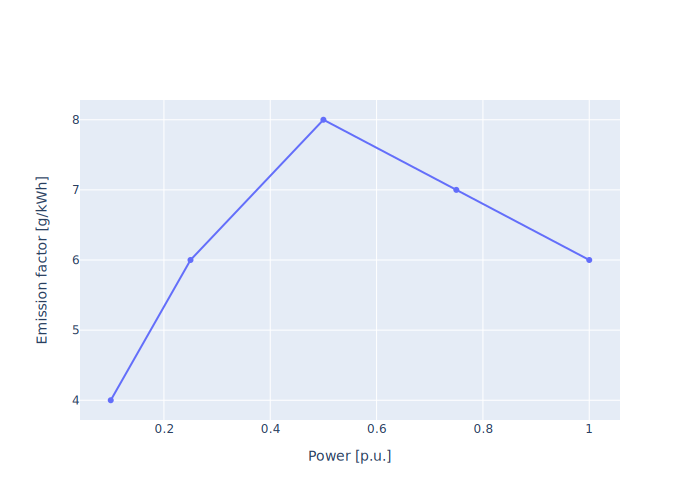

In [ ]:
#| hide
# Test EmissionFactor
rated_power_kw = random.random() * 1000
power_kw = (0.1 + 0.9 * random.random()) * rated_power_kw
power_load_ratio = power_kw / rated_power_kw
emission_curve = Curve(points=[
    Point(x=0.1, y=4),
    Point(x=0.25, y=6),
    Point(x=0.5, y=8),
    Point(x=0.75, y=7),
    Point(x=1.0, y=6)
])
emission_factor_interpolated = interp1d(
    x=emission_curve.to_x_array(),
    y=emission_curve.to_y_array(),
    kind="cubic"
)(power_load_ratio)
emissions_ref = emission_factor_interpolated * power_kw / 1000
emission_factor = EmissionFactor(
    factor=emission_curve,
    emission_type=EmissionType.NOX,
    rated_power_kw=rated_power_kw
)
emission_factor.get_emission_plot().show(renderer="svg")
emission_calculated = emission_factor.get_emission_kg_per_h(power_kw)
assert np.isclose(emission_calculated, emissions_ref), \
    f"Emission value is not correct: {emission_calculated} vs {emissions_ref}"

In [ ]:
#| hide
# Test Emissions
import random

emissions_types1 = np.random.choice(EmissionType, size=2, replace=False)
emissions_types2 = np.random.choice(EmissionType, size=2, replace=False)
arg_to_emissions1 = {each_type.value: random.random() * 10 for each_type in emissions_types1}
arg_to_emissions2 = {each_type.value: random.random() * 10 for each_type in emissions_types2}
emissions1 = Emissions(**arg_to_emissions1)
emissions2 = Emissions(**arg_to_emissions2)
emissions_total = emissions1 + emissions2
for key in EmissionType:
    emission_name = key.value
    assert np.isclose(
        getattr(emissions_total, emission_name),
        getattr(emissions1, emission_name) + getattr(emissions2, emission_name)
    ), f"{emission_name} emissions not added correctly"

# Test MachineryResult
power_kw1 = random.random() * 100
power_kw2 = random.random() * 100
fuel_consumption1 = FuelConsumption(
    total_fuel_consumption=random.random() * 100,
    fuel_by_mass_fraction=FuelByMassFraction(diesel=1.0)
)
fuel_consumption2 = FuelConsumption(
    total_fuel_consumption=random.random() * 100,
    fuel_by_mass_fraction=FuelByMassFraction(diesel=1.0)
)
machinery_result1 = MachineryResult(
    power_on_source_kw=power_kw1,
    fuel_consumption=fuel_consumption1,
    emissions=emissions1
)
machinery_result2 = MachineryResult(
    power_on_source_kw=power_kw2,
    fuel_consumption=fuel_consumption2,
    emissions=emissions2
)
machinery_result_total = machinery_result1 + machinery_result2
assert np.isclose(machinery_result_total.power_on_source_kw, power_kw1 + power_kw2), "Power not added correctly"
assert np.isclose(
    machinery_result_total.fuel_consumption.total_fuel_consumption,
    fuel_consumption1.total_fuel_consumption + fuel_consumption2.total_fuel_consumption
), "Fuel consumption not added correctly"
for key in EmissionType:
    emission_name = key.value
    assert np.isclose(
        getattr(machinery_result_total.emissions, emission_name),
        getattr(emissions1, emission_name) + getattr(emissions2, emission_name)
    ), f"{emission_name} emissions not added correctly"

## Power Source and Load
Power sources are used to calculate the fuel consumption and emissions for the given power output

In [ ]:
#| export
@dataclass(kw_only=True)
class PowerSource(ABC):
    fuel: FuelByMassFraction
    rated_power_kw: float
    emission_factors: List[EmissionFactor] = field(default_factory=list)

    @abstractmethod
    def get_specific_fuel_consumption_g_per_kwh(
            self, power_out_kw: Optional[Numeric] = None
    ) -> Numeric:
        pass

    def get_fuel_consumption_kg_per_h(self, power_out_kw: float) -> FuelConsumption:
        """Returns the fuel consumption (kg/h)"""
        total_fuel_consumption_kg_per_h = self.get_specific_fuel_consumption_g_per_kwh(
            power_out_kw=power_out_kw
        ) * power_out_kw / 1000
        return FuelConsumption(
            total_fuel_consumption=total_fuel_consumption_kg_per_h,
            fuel_by_mass_fraction=self.fuel
        )

    def get_emissions_kg_per_h(self, power_out_kw: float) -> Emissions:
        """Returns the emissions (kg/h)"""
        emissions = Emissions()
        for emission_factor in self.emission_factors:
            emissions.__setattr__(
                emission_factor.emission_type.value,
                emission_factor.get_emission_kg_per_h(power_out_kw)
            )
        return emissions

    def get_machinery_result(self, power_out_kw: float) -> MachineryResult:
        return MachineryResult(
            power_on_source_kw=power_out_kw,
            fuel_consumption=self.get_fuel_consumption_kg_per_h(power_out_kw),
            emissions=self.get_emissions_kg_per_h(power_out_kw)
        )


@dataclass(kw_only=True)
class PowerSourceWithEfficiency(PowerSource):
    """Power source with efficiency as a scalar or a curve

    The efficiency can be a scalar or a curve. When it is a curve, x is power output that is
    normalized to the rated power of the power source, and y is the efficiency.
    """
    efficiency: Union[float, Curve]

    @property
    def _has_scalar_efficiency(self):
        return isinstance(self.efficiency, float) or isinstance(self.efficiency, int)

    @cached_property
    def _engine_efficiency_curve_interpolator(self):
        """
        Interpolates the engine efficiency based on output load-efficiency curve in a specific load.
        This is independent of the engine speed.
        """
        assert not self._has_scalar_efficiency, "Engine efficiency is a scalar, not a curve."
        return get_interpolation_1d_function(
            x=self.efficiency.to_x_array(),
            y=self.efficiency.to_y_array(),
            add_origo=False
        )

    def get_specific_fuel_consumption_g_per_kwh(
            self, power_out_kw: Optional[Numeric] = None
    ) -> Numeric:
        """
        Returns the specific fuel consumption of engine (g/kw.h)
        """
        if self._has_scalar_efficiency:
            return 1 / self.efficiency / self.fuel.lhv_mj_per_kg * 3600
        else:
            shaft_power_normalized = power_out_kw / self.rated_power_kw
            efficiency = self._engine_efficiency_curve_interpolator(shaft_power_normalized).value
            return 1 / efficiency / self.fuel.lhv_mj_per_kg * 3600


@dataclass(kw_only=True)
class PowerSourceWithSpecificFuelConsumption(PowerSource):
    """Power source with a specific fuel consumption defined as a scalar or a curve

    The specific fuel consumption is defined as g/kWh. It can be a scalar or a curve.
    If it is a curve, the curve is defined as a function of the power output normalized
    by the rated power.
    """
    specific_fuel_consumption: Union[float, Curve]

    @property
    def _has_scalar_specific_fuel_consumption(self):
        return isinstance(self.specific_fuel_consumption, float) \
               or isinstance(self.specific_fuel_consumption, int)

    @cached_property
    def _specific_fuel_consumption_curve_interpolator(self):
        """
        Interpolates the specific fuel consumption based on input load-specific fuel consumption
        curve in a specific load. This is independent of the engine speed.
        """
        assert not self._has_scalar_specific_fuel_consumption, \
            "Specific fuel consumption is a scalar, not a curve."
        return get_interpolation_1d_function(
            x=self.specific_fuel_consumption.to_x_array(),
            y=self.specific_fuel_consumption.to_y_array(),
            add_origo=False
        )

    def get_specific_fuel_consumption_g_per_kwh(
            self, power_out_kw: Optional[Numeric] = None
    ) -> Numeric:
        """
        Returns the specific fuel consumption of engine (g/kwh)
        """
        if self._has_scalar_specific_fuel_consumption:
            return self.specific_fuel_consumption
        else:
            shaft_power_normalized = power_out_kw / self.rated_power_kw
            return self._specific_fuel_consumption_curve_interpolator(shaft_power_normalized).value


@dataclass
class PowerLoad:
    """class for load in a MachinerySubsystemSimple

    When the efficiency is given a scalar, it should be a value between 0 and 1. If it is a curve,
    the x-axis should be the load (power out / rated power, 0~1) and the y-axis should be the
    efficiency (0~1). When the efficiency is a curve, rated power should be defined.
    """
    efficiency: Union[float, Curve]
    rated_power_kw: Optional[float] = None

    def __post_init__(self):
        """Check if the efficiency is a scalar or a curve"""
        if not self._has_scalar_efficiency and self.rated_power_kw is None:
            raise ValueError("Rated power should be defined when efficiency is a curve.")

    @property
    def _has_scalar_efficiency(self):
        """Check if the efficiency is a scalar or a curve"""
        return isinstance(self.efficiency, float) or isinstance(self.efficiency, int)

    @cached_property
    def _efficiency_curve_interpolator(self):
        """
        Interpolates the efficiency based on output load-efficiency curve in a specific load.
        This is independent of the engine speed.
        """
        assert not self._has_scalar_efficiency, "Efficiency is a scalar, not a curve."
        return get_interpolation_1d_function(
            x=self.efficiency.to_x_array(),
            y=self.efficiency.to_y_array(),
            add_origo=False
        )

    def get_efficiency(self, power_out_kw: Numeric) -> Numeric:
        """Returns the internal efficiency of the load"""
        if self._has_scalar_efficiency:
            return self.efficiency
        else:
            return self._efficiency_curve_interpolator(power_out_kw / self.rated_power_kw).value

    def get_power_in_kw(self, power_out_kw: Numeric) -> Numeric:
        """Returns the power input to the load from power output"""
        return power_out_kw / self.get_efficiency(power_out_kw)


## Test PowerSource and PowerLoad class

In [ ]:
#| hide
import random
import numpy as np
from scipy.interpolate import interp1d
from ship_model_lib.machinery import (
    Point,
    Curve,
    EmissionType,
    EmissionFactor,
    PowerSourceWithEfficiency,
    PowerSourceWithSpecificFuelConsumption,
)

In [ ]:
#| hide
# Testing power source with scalar efficiency
fuel = create_random_fuel()
efficiency = random.random()
specific_fuel_consumption_ref_g_per_kwh = 1 / efficiency / fuel.lhv_mj_per_kg * 3600
emission_factor_value = random.random()
rated_power_kw = random.random() * 1000
emission_factor = EmissionFactor(
    emission_type=EmissionType.CO2,
    factor=emission_factor_value,
    rated_power_kw=rated_power_kw
)
power_source = PowerSourceWithEfficiency(
    fuel=fuel,
    efficiency=efficiency,
    rated_power_kw=rated_power_kw,
    emission_factors=[emission_factor]
)
# Test scalar efficiency property
assert power_source._has_scalar_efficiency, "Power source should have scalar efficiency."
# Test specific fuel consumption
assert np.isclose(
    power_source.get_specific_fuel_consumption_g_per_kwh(),
    specific_fuel_consumption_ref_g_per_kwh
), "Specific fuel consumption should be equal to reference value."
# Test fuel consumption with scalar input
power_load_scalar = random.random() * rated_power_kw
assert np.isclose(
    power_source.get_fuel_consumption_kg_per_h(power_load_scalar).total_fuel_consumption,
    specific_fuel_consumption_ref_g_per_kwh * power_load_scalar / 1000
), "Fuel consumption should be equal to reference value."
# Test fuel consumption with array input
power_load_array = np.random.random(100) * rated_power_kw
assert np.allclose(
    power_source.get_fuel_consumption_kg_per_h(power_load_array).total_fuel_consumption,
    specific_fuel_consumption_ref_g_per_kwh * power_load_array / 1000
), "Fuel consumption should be equal to reference value."
# Test emissions with scalar input
emission_calculated = power_source.get_emissions_kg_per_h(power_load_scalar)
emission_ref = emission_factor_value * power_load_scalar / 1000
assert np.isclose(emission_calculated.co2, emission_ref), \
    f"Emissions should be equal to reference value ({emission_calculated.co2} vs {emission_ref})."
# Test emissions with array input
emission_calculated = power_source.get_emissions_kg_per_h(power_load_array)
emission_ref = emission_factor_value * power_load_array / 1000
assert np.allclose(emission_calculated.co2, emission_ref), \
     "Emissions should be equal to reference value."

# Testing power source with curve efficiency
efficiency_curve = Curve(points=[
    Point(x=0.0, y=0.0),
    Point(x=0.1, y=0.4),
    Point(x=0.25, y=0.5),
    Point(x=0.5, y=0.4),
    Point(x=0.75, y=0.3),
    Point(x=1.0, y=0.2)
])
specific_fuel_consumption_ref_g_per_kwh = 1 / interp1d(
    x=efficiency_curve.to_x_array(),
    y=efficiency_curve.to_y_array(),
    kind="cubic",
)(power_load_array / rated_power_kw) / fuel.lhv_mj_per_kg * 3600
power_source = PowerSourceWithEfficiency(
    fuel=fuel,
    efficiency=efficiency_curve,
    rated_power_kw=rated_power_kw,
    emission_factors=[emission_factor]
)
# Test curve efficiency property
assert not power_source._has_scalar_efficiency, "Power source should have curve efficiency."
# Test specific fuel consumption
assert np.allclose(
    power_source.get_specific_fuel_consumption_g_per_kwh(power_load_array),
    specific_fuel_consumption_ref_g_per_kwh
), "Specific fuel consumption should be equal to reference value."
# Test fuel consumption
fuel_consumption_calculated = \
    power_source.get_fuel_consumption_kg_per_h(power_load_array).total_fuel_consumption
fuel_consumption_ref = specific_fuel_consumption_ref_g_per_kwh * power_load_array / 1000
assert np.allclose(fuel_consumption_calculated, fuel_consumption_ref)
# Test emiisions
emission_calculated = power_source.get_emissions_kg_per_h(power_load_array)
emission_ref = emission_factor_value * power_load_array / 1000
assert np.allclose(emission_calculated.co2, emission_ref), \
     "Emissions should be equal to reference value."
# Test machinery result
machinery_result = power_source.get_machinery_result(power_load_array)
assert np.allclose(power_load_array, machinery_result.power_on_source_kw)
assert np.allclose(fuel_consumption_ref, machinery_result.fuel_consumption.total_fuel_consumption)
assert np.allclose(emission_ref, machinery_result.emissions.co2)

In [ ]:
#| hide
# Testing power source with scalar specific consumption
specific_fuel_consumption_ref_g_per_kwh = 100 + random.random() * 100
emission_factor_value = random.random()
rated_power_kw = random.random() * 1000
emission_factor = EmissionFactor(
    emission_type=EmissionType.CO2,
    factor=emission_factor_value,
    rated_power_kw=rated_power_kw
)
power_source = PowerSourceWithSpecificFuelConsumption(
    fuel=fuel,
    specific_fuel_consumption=specific_fuel_consumption_ref_g_per_kwh,
    rated_power_kw=rated_power_kw,
    emission_factors=[emission_factor]
)
# Test scalar efficiency property
assert power_source._has_scalar_specific_fuel_consumption, "Power source should have scalar specific fuel consumption."
# Test fuel consumption with scalar input
power_load_scalar = random.random() * rated_power_kw
fuel_consumption_calculated = \
    power_source.get_fuel_consumption_kg_per_h(power_load_scalar).total_fuel_consumption
fuel_consumption_ref = specific_fuel_consumption_ref_g_per_kwh * power_load_scalar / 1000
assert np.isclose(fuel_consumption_calculated, fuel_consumption_ref), "Fuel consumption should be equal to reference value."
# Test fuel consumption with array input
power_load_array = np.random.random(100) * rated_power_kw
fuel_consumption_calculated = \
    power_source.get_fuel_consumption_kg_per_h(power_load_array).total_fuel_consumption
fuel_consumption_ref = specific_fuel_consumption_ref_g_per_kwh * power_load_array / 1000
assert np.allclose(fuel_consumption_calculated, fuel_consumption_ref), \
    "Fuel consumption should be equal to reference value."

# Testing power source with curve specific fuel consumption
specific_fuel_consumption_curve = Curve(points=[
    Point(x=0.0, y=300),
    Point(x=0.1, y=274),
    Point(x=0.25, y=250),
    Point(x=0.5, y=220),
    Point(x=0.75, y=210),
    Point(x=1.0, y=220)
])
specific_fuel_consumption_ref_g_per_kwh = interp1d(
    x=specific_fuel_consumption_curve.to_x_array(),
    y=specific_fuel_consumption_curve.to_y_array(),
    kind="cubic",
)(power_load_array / rated_power_kw)
power_source = PowerSourceWithSpecificFuelConsumption(
    fuel=fuel,
    specific_fuel_consumption=specific_fuel_consumption_curve,
    rated_power_kw=rated_power_kw,
    emission_factors=[emission_factor]
)
# Test curve efficiency property
assert not power_source._has_scalar_specific_fuel_consumption, "Power source should have curve specific fuel consumption."
# Test specific fuel consumption
assert np.allclose(
    power_source.get_specific_fuel_consumption_g_per_kwh(power_load_array),
    specific_fuel_consumption_ref_g_per_kwh
), "Specific fuel consumption should be equal to reference value."
# Test fuel consumption
fuel_consumption_calculated = \
    power_source.get_fuel_consumption_kg_per_h(power_load_array).total_fuel_consumption
fuel_consumption_ref = specific_fuel_consumption_ref_g_per_kwh * power_load_array / 1000
assert np.allclose(fuel_consumption_calculated, fuel_consumption_ref)
# Test machinery result
machinery_result = power_source.get_machinery_result(power_load_array)
assert np.allclose(power_load_array, machinery_result.power_on_source_kw)
assert np.allclose(fuel_consumption_ref, machinery_result.fuel_consumption.total_fuel_consumption)

## Machinery System

In [ ]:
#| export
@dataclass
class MachinerySubsystemSimple:
    """Simple machinery subsystem

    A simple machinery subsystem has a single power source and two power loads.
    One power load is the propulsion load, and the other is the auxiliary load
    (or all other loads other than propulsion).

    The intention is to distinguish between the propulsion load and the other loads.
    Propulsion load is the shaft power of the propeller and the other loads are the
    power consumption at the switchboard or a main shaft.
    """
    power_source: Union[
        PowerSourceWithEfficiency,
        PowerSourceWithSpecificFuelConsumption
    ]
    propulsion_load: PowerLoad = None
    auxiliary_load: PowerLoad = None

    def get_machinery_result(self, load: LoadInput) -> MachineryResult:
        """Returns the machinery result"""
        propulsion_load_on_power_source = self.propulsion_load.get_power_in_kw(
            load.propulsion_load_kw
        ) if self.propulsion_load is not None else 0
        aux_load_on_power_source = self.auxiliary_load.get_power_in_kw(
            load.auxiliary_load_kw
        ) if self.auxiliary_load is not None else 0
        total_power_on_power_source = propulsion_load_on_power_source + aux_load_on_power_source
        return self.power_source.get_machinery_result(total_power_on_power_source)


@dataclass
class MachinerySystem:
    """Class for a machinery system

    The machinery system is consisted of two machinery subsystems: one is the mechanical system
    and the other is the electric system. If the propulsion type is `mechanical`, the electric
    system represents the auxiliary power system whereas the mechanical system represents the
    propulsion system. If the propulsion type is `electric`, the electric system represents both
    whereas the mechanical system should be None.
    """
    propulsion_type: PropulsionType
    mechanical_system: MachinerySubsystemSimple = None
    electric_system: MachinerySubsystemSimple = None

    def __post_init__(self):
        if self.propulsion_type == PropulsionType.MECHANICAL and self.mechanical_system is None:
            raise ValueError("Mechanical system should be defined when propulsion type is "
                             "mechanical.")
        if self.propulsion_type == PropulsionType.ELECTRIC \
                and self.electric_system is None and self.mechanical_system is not None:
            raise ValueError("Electric system should be defined when propulsion type is "
                             "electric.")

    @property
    def has_mechanical_system(self):
        return self.mechanical_system is not None

    @property
    def has_electric_system(self):
        return self.electric_system is not None

    def get_machinery_result(
        self,
        mechanical_load: Optional[LoadInput] = None,
        electric_load: Optional[LoadInput] = None
    ) -> MachinerySystemResult:
        """Returns the machinery result which contains fuel consumption and power consumption at
        the power source for each subsystem and total.

        If the propulsion type is `mechanical`, the mechanical load should be given with the
        propulsion load whereas the electric load should be given only with the auxiliary load.
        If the propulsion type is `electric`, the electric load should be given with both the
        propulsion load and the auxiliary load. The mechanical load should not be given.
        """
        # Check if the subsystem is defined for the power inputs
        if mechanical_load is not None and not self.has_mechanical_system:
            raise TypeError("Mechanical system is not defined")
        if electric_load is not None and not self.has_electric_system:
            raise TypeError("Electric system is not defined but electric load is given.")
        if self.propulsion_type == PropulsionType.MECHANICAL \
                and electric_load is not None and electric_load.propulsion_load_kw > 0:
            raise ValueError("Propulsion load should not be given with the electric load when "
                             "propulsion type is mechanical.")

        # Setting the default values with null values
        result_mechanical = MachineryResult()
        result_electric = MachineryResult()

        # Calculate fuel consumption for mechanical system
        if self.has_mechanical_system:
            assert mechanical_load is not None, \
                "Mechanical consumer power must be provided if the machinery system " \
                "has a mechanical system."
            result_mechanical = self.mechanical_system.get_machinery_result(mechanical_load)

        # Calculate fuel consumption for electric system
        if self.has_electric_system:
            assert electric_load is not None, \
                "Electric consumer power must be provided " \
                "if the machinery system has an electric system."
            result_electric = self.electric_system.get_machinery_result(electric_load)
        if not self.has_mechanical_system and not self.has_electric_system:
            raise TypeError("Machinery system is not defined")

        return MachinerySystemResult(
            mechanical_system=result_mechanical,
            electric_system=result_electric,
            total=result_mechanical + result_electric
        )

Test MachinerySystem

In [ ]:
#| hide
import numpy as np
import pytest
import random

from ship_model_lib.machinery import (
    MachinerySubsystemSimple,
    FuelByMassFraction,
    EmissionFactor,
    EmissionType,
    PowerSourceWithEfficiency,
    PowerSourceWithSpecificFuelConsumption,
    MachineryResult,
    MachinerySystem,
    PowerLoad,
    LoadInput,
    PropulsionType
)

In [ ]:
#| hide
rated_power_kw = 1000 * random.random()
efficiency = random.random()
fuel = create_random_fuel()
emission_factors = []
for emission_type in np.random.choice(EmissionType, size=2, replace=False):
    emission_factors.append(EmissionFactor(
        emission_type=emission_type,
        factor=random.random() * 10,
        rated_power_kw=rated_power_kw,
    ))
power_source = PowerSourceWithEfficiency(
    fuel=fuel,
    efficiency=random.random(),
    rated_power_kw=1000 * random.random(),
    emission_factors=emission_factors,
)
power_load_efficiency = 0.9854
power_load = PowerLoad(efficiency=efficiency)
subsystem = MachinerySubsystemSimple(
    power_source=power_source,
    propulsion_load=power_load,
)

power_load_scalar = rated_power_kw * random.random()
power_out_power_source_ref = power_load_scalar / efficiency
fuel_consumption = power_source.get_fuel_consumption_kg_per_h(power_out_power_source_ref)
emissions = power_source.get_emissions_kg_per_h(power_out_power_source_ref)
load_input = LoadInput(propulsion_load_kw=power_load_scalar)
machinery_result = subsystem.get_machinery_result(load_input)
# Test if load is included in the result
assert np.isclose(power_out_power_source_ref, machinery_result.power_on_source_kw)

# Test the fuel consumptions and emissions
assert np.isclose(
    fuel_consumption.total_fuel_consumption,
    machinery_result.fuel_consumption.total_fuel_consumption
)
for key in emissions.__dict__:
    assert np.isclose(emissions.__dict__[key], machinery_result.emissions.__dict__[key])

In [ ]:
#| hide
# Test Machinery system
power_load_for_electric_system = PowerLoad(efficiency=1.0)
electric_system = MachinerySubsystemSimple(
    power_source=power_source,
    auxiliary_load=power_load_for_electric_system
)
rated_power_for_mechanical_system = 1000 * random.random()
specific_fuel_consumption_ref_g_per_kwh = 180
shaft_efficiency = 0.99
electric_power_output = electric_system.power_source.rated_power_kw * random.random()
mechanical_power_output_kw = rated_power_for_mechanical_system * random.random()
mechanical_load_input = LoadInput
power_source_for_mechanical_system = PowerSourceWithSpecificFuelConsumption(
    rated_power_kw=rated_power_for_mechanical_system,
    fuel=fuel,
    specific_fuel_consumption=specific_fuel_consumption_ref_g_per_kwh,
    emission_factors=emission_factors
)
power_load_for_mechanical_system = PowerLoad(efficiency=shaft_efficiency)
mechanical_system = MachinerySubsystemSimple(
    power_source=power_source_for_mechanical_system,
    propulsion_load=power_load_for_mechanical_system,
)
load_input_for_mechanical_system = LoadInput(
    propulsion_load_kw=mechanical_power_output_kw
)
load_input_for_electric_system = LoadInput(
    auxiliary_load_kw=electric_power_output
)
result_mechanical_system = mechanical_system.get_machinery_result(load_input_for_mechanical_system)
result_electric_system = electric_system.get_machinery_result(load_input_for_electric_system)
machinery_system = MachinerySystem(
    propulsion_type=PropulsionType.MECHANICAL,
    mechanical_system=mechanical_system,
    electric_system=electric_system
)
result = machinery_system.get_machinery_result(
    mechanical_load=load_input_for_mechanical_system,
    electric_load=load_input_for_electric_system
)
print(emission_factors)
print(result)

# Test
assert np.isclose(
    result.mechanical_system.fuel_consumption.total_fuel_consumption,
    result_mechanical_system.fuel_consumption.total_fuel_consumption
)
assert np.allclose(result.mechanical_system.power_on_source_kw, result_mechanical_system.power_on_source_kw)
for key in EmissionType:
    assert np.isclose(
        getattr(result.mechanical_system.emissions, key.value),
        getattr(result_mechanical_system.emissions, key.value)
    )
assert np.isclose(
    result.electric_system.fuel_consumption.total_fuel_consumption,
    result_electric_system.fuel_consumption.total_fuel_consumption
)
assert np.allclose(result.electric_system.power_on_source_kw, result_electric_system.power_on_source_kw)
for key in EmissionType:
    assert np.isclose(
        getattr(result.electric_system.emissions, key.value),
        getattr(result_electric_system.emissions, key.value)
    )
assert np.isclose(
    result.total.fuel_consumption.total_fuel_consumption,
    result_electric_system.fuel_consumption.total_fuel_consumption
    + result_mechanical_system.fuel_consumption.total_fuel_consumption
)
assert np.allclose(
    result.total.power_on_source_kw,
    result_mechanical_system.power_on_source_kw + result_electric_system.power_on_source_kw
)
for key in EmissionType:
    assert np.isclose(
        getattr(result.total.emissions, key.value),
        getattr(result_electric_system.emissions, key.value)
        + getattr(result_mechanical_system.emissions, key.value)
    )

[EmissionFactor(rated_power_kw=418.9312539570063, factor=6.743339479989158, emission_type=<EmissionType.SOX: 'sox'>), EmissionFactor(rated_power_kw=418.9312539570063, factor=3.3257325283077463, emission_type=<EmissionType.CO2: 'co2'>)]
MachinerySystemResult(total=MachineryResult(power_on_source_kw=790.656990235055, fuel_consumption=<ship_model_lib.machinery.FuelConsumption object>, emissions=Emissions(co2=2.6295136711586227, sox=5.3316684973814485, nox=0.0, pm=0.0)), mechanical_system=MachineryResult(power_on_source_kw=509.81391237968984, fuel_consumption=<ship_model_lib.machinery.FuelConsumption object>, emissions=Emissions(co2=1.6955047117849698, sox=3.4378482827976957, nox=0.0, pm=0.0)), electric_system=MachineryResult(power_on_source_kw=280.84307785536515, fuel_consumption=<ship_model_lib.machinery.FuelConsumption object>, emissions=Emissions(co2=0.9340089593736528, sox=1.8938202145837526, nox=0.0, pm=0.0)))
